In [3]:
!pip3 install transformers

In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import BertForSequenceClassification, BertTokenizerFast
from transformers import Trainer, TrainingArguments
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker

C:\Users\HepsiBTC\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
C:\Users\HepsiBTC\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [5]:
# veri setini import işlemi
import pandas as pd
dataframe = pd.read_csv('Suicide_Detection.csv')
dataframe.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [6]:
# Bu komutlar, veriyi sınıflarına göre ayırır ve her bir sınıfın boyutunu kontrol etmenizi sağlar.
suicide = dataframe[dataframe['class']=='suicide']
non_suicide = dataframe[dataframe['class']=='non-suicide']
suicide.shape, non_suicide.shape

((116037, 3), (116037, 3))

In [21]:
# Bu komutlar, veri setini dengeli hale getirmek için her iki sınıftan eşit sayıda örnek alır ve 
# yeni birleştirilmiş bir veri seti oluşturur.
suicide = suicide.head(30000)
non_suicide = non_suicide.head(30000)
dataframe = pd.concat([suicide,non_suicide])
dataframe.shape

(60000, 3)

In [22]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60000 entries, 0 to 59826
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  60000 non-null  int64 
 1   text        60000 non-null  object
 2   class       60000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.8+ MB


In [23]:
# text ve class sütunlarında hiç eksik değer olmadığını gösterir. 
dataframe.isnull().sum()

Unnamed: 0    0
text          0
class         0
dtype: int64

### ön işleme

In [24]:
import re
!pip install autocorrect
from autocorrect import Speller
!pip install unidecode
import unidecode
!pip install contractions
import contractions
from string import punctuation

In [25]:
def text_cleaning(text):
    # Gönderilen metni küçük harfe dönüştürür
    text = text.lower()

    # Metinden tüm HTML etiketlerini temizler.
    html_pattern = r'<.*?>'
    text = re.sub(pattern=html_pattern, repl=' ', string=text)

    # Metinden tüm URL'leri temizler.
    url_pattern = r'https?://\S+|www\.\S+'
    text = re.sub(pattern=url_pattern, repl=' ', string=text)

    # Metinden tüm rakamları temizler.
    number_pattern = r'\d+'
    text = re.sub(pattern=number_pattern, repl=' ', string=text)

    # Unicode karakterlerini ASCII karakterlere dönüştürür.
    text = unidecode.unidecode(text)

    # Kısaltmaları genişleterek tam kelimeler haline getirir.
    text = contractions.fix(text)

    # Noktalama işaretlerini kaldırır.
    text = text.translate(str.maketrans('', '', punctuation))

    # Tek harfli kelimeleri kaldırır.
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    text = re.sub(pattern=single_char_pattern, repl=" ", string=text)

    # Ekstra boşlukları kaldırır.
    space_pattern = r'\s+'
    text = re.sub(pattern=space_pattern, repl=" ", string=text)

    return text

In [27]:
dataframe['text'] = dataframe['text'].apply(text_cleaning)
dataframe.head(100)

,Unnamed: 0,text,class
0,2,ex wife threatening suiciderecently left my wi...,suicide
3,8,i need helpjust help me am crying so hard,suicide
4,9,i am so losthello my name is adam and have bee...,suicide
5,11,honetly idki do not know what am even doing he...,suicide
6,12,trigger warning excuse for self inflicted burn...,suicide
...,...,...,...
193,283,the cold sore did me inlet me prefix this with...,suicide
194,284,cannot shake the suicidal ideationive struggle...,suicide
195,285,can somebody talk to methere is shit in my lif...,suicide
196,287,police visit ukthrowaway due to obvious reason...,suicide


In [28]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
nltk.download('stopwords')
nltk.download('punkt')
lists = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HepsiBTC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HepsiBTC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [29]:
stopwords_list = ['i', 'am', 'is','are','this','that','then','those','have','has','it','can','could','the','had','was','were','been','them',
                  'what','whose','whom','who','do','did','does' 'yet', 'though', 'wherein', 'really', 'show', 'then', 'rather', 'same', 'con', 'call', 'is', 'twenty', 'side', 'go', 'namely',
                  'every', 'top', 'for', "'m", 'with', 'either', 'because', 'two', 'well', 'when', 'those', 'under', 'thin', 'amount', 'upon', 
                  'kg', 'the', "that'll", 'ca', 'even', 'very', 'into', 'by', '‘m', 'keep', 'although', 'done', 'bottom', 'detail', 'whatever', 
                  'from', 'formerly', 'these', 'enough', 'twelve', 'of', 'too', 'already', 'move', 'something', 'few', 'nothing', 'they', 'does',
                  'us', 'next', 'cry', 'but', 'eight', '‘s', 'however', 'four', "'ll", 'has', 'over', 'someone', 'afterwards', 'myself', 'have',
                  'would', 'anywhere', 'hereupon', 'using', 'everything', 'his', 'put', 'many', 'more', 'within', 'which', 'describe', 'thereby',
                  'nine', 'elsewhere', 'other', 'he', 'if', 'per', 'your', 's', 'be', 'than', 'now', 'sometime', 'herein', 'why', '‘d', 'whereas',
                  'behind', 'couldnt', 'de', "'re", 'least', 'latter', 'whereafter', 'part', 'after', 'front', 'interest', "you'd", 'whose', 'fire',
                  'sincere', 'down', 'to', 'whence', 'ours', "'s", 'all', 'noone', 'just', 'anyhow', 'ie', 'having', 'her', 'been', 'get', 'former', 
                  'throughout', 'above', '’d', 'cannot', 'almost', 'do', 'quite', 'seem', 'give', 'first', 'several', 'also', 'seems', 'became', '’m',
                  'sixty', 'anyway', '‘re', 'on', "you're", 'onto', 'co', 'third', 'fifty', 'had', 'seemed', '’s', 'yourselves', 'until', 'an', 'mine',
                  'across', 'sometimes', 'hereby', 'eleven', 'might', 'mostly', 'un', 'i', "'d", 'itself', 'most', 'beforehand', 'five', 'beyond',
                  'herself', "you've", 'unless', 'regarding', 'there', 'doesn', 'while', 'whoever', "should've", 'whereupon', 'name', 'further', 'o', 
                  'nobody', 'whereby', 'others', 'between', 'thus', 'any', "you'll", 'found', 'amongst', 'hers', 'wherever', 'ltd', 'still', 'somehow',
                  'often', 'km', 'becoming', 'six', 'can', "'ve", 'make', 'hence', 'around', 'both', 'our', 'along', 'latterly', 'please', 'via', 'whole',
                  'system', 've', 'd', 'you', 'themselves', 'here', 'used', 'in', 'forty', 'each', 'find', 'during', 'ain', 'ten', 'him', 'nevertheless',
                  "she's", 'me', 'them', 'ma', 'meanwhile', 'and', 'y', 'did', 'fifteen', 'serious', '’re', "it's", '’ll', 'that', 'alone', 'together', 
                  'where', 'hereafter', 'once', 'himself', 'could', 'made', 'among', 'whom', 'cant', 'doing', 'again', 'therefore', 'beside', 'hundred',
                  'three', 'etc', 'moreover', 'various', 'may', 'since', 'always', 'seeming', 'toward', 'are', 'll', 'everywhere', 'a', 'empty', 'yours',
                  'theirs', 'back', 'else', 'own', 'as', 'somewhere', 'bill', '‘ll', 're', 'through', 'last', 'nowhere', 'what', 'take', 'computer',
                  'yourself', 'eg', 'perhaps', 'thereupon', 'ourselves', 'against', 'inc', 'she', 'whether', 'their', 'm', 'such', 'thick', 'anything',
                  '’ve', 'neither', 'none', 'amoungst', 'one', 'were', 'thru', 'am', 'about', 'without', 'up', 'otherwise', 'except', 'who', 'due',
                  'thereafter', 'ever', 'much', 'out', 'how', 'whenever', 'before', 'it', 'some', 'being', 'mill', 'or', 'its', 'will', 'become',
                  'besides', 'say', 'therein', 'another', 'see', 'anyone', 'becomes', 'never', 'towards', 'everyone', 'below', 'full', 'my', 'only', 
                  'fill', 'we', 'should', 'thence', 'indeed', 'this', 'was', 'less', 'so', 't', 'at', 'must', 'whither', 'off'
]

In [30]:
def remove_stopwords(text):
    token = word_tokenize(text)
    token_without_stopwords = []
    for words in token:
        if words not in stopwords_list:
            token_without_stopwords.append(words)
    text = " ".join(token_without_stopwords)
    return text

In [31]:
dataframe['text'] = dataframe['text'].apply(remove_stopwords)
dataframe.head(100)

,Unnamed: 0,text,class
0,2,ex wife threatening suiciderecently left wife ...,suicide
3,8,need helpjust help crying hard,suicide
4,9,losthello adam struggling years afraid past ye...,suicide
5,11,honetly idki not know feel like feel unbearabl...,suicide
6,12,trigger warning excuse self inflicted burnsi k...,suicide
...,...,...,...
193,283,cold sore inlet prefix saying cold sores not b...,suicide
194,284,not shake suicidal ideationive struggled depre...,suicide
195,285,somebody talk methere shit life need talk mayb...,suicide
196,287,police visit ukthrowaway obvious reasons night...,suicide


In [32]:
dataframe['class']=pd.factorize(dataframe['class'])[0]

In [33]:
dataframe.head(10)

,Unnamed: 0,text,class
0,2,ex wife threatening suiciderecently left wife ...,0
3,8,need helpjust help crying hard,0
4,9,losthello adam struggling years afraid past ye...,0
5,11,honetly idki not know feel like feel unbearabl...,0
6,12,trigger warning excuse self inflicted burnsi k...,0
7,13,ends tonighti not anymore quit,0
9,18,life years oldhello year old balding male hair...,0
10,19,took rest sleeping pills painkillersi not wait...,0
11,20,imagine getting old neitherwrinkles weight gai...,0
12,21,think getting hit train painfulguns hard come ...,0


In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
Tfidf_Vector = TfidfVectorizer(min_df = 0., max_df = 1., use_idf = True,max_features=300)
Tfidf_Matrix = Tfidf_Vector.fit_transform(dataframe["text"].values.astype('U'))
Tfidf_Matrix = Tfidf_Matrix.toarray()
#Tfidf_Vector içerisindeki tüm öznitelikleri al
features = Tfidf_Vector.get_feature_names_out()
# Doküman - öznitelik matrisini göster
Tfidf_df = pd.DataFrame(np.round(Tfidf_Matrix, 3), columns = features)
Tfidf_df.to_csv("Tfidf_df.cvs",index=False)

In [40]:
y = pd.DataFrame() 
x = Tfidf_Matrix
x = (x - np.min(x))/(np.max(x)-np.min(x))
y["class"] = dataframe["class"]
y = y.values

In [43]:
from sklearn.model_selection import train_test_split as tts
sonuclar = pd.DataFrame()
Accuracy = pd.DataFrame()
x_train,x_test,y_train,y_test = tts(x,y,test_size=0.3,random_state=1)
sonuclar["class"] = y_test[:,0]
y_train = y_train[:,0].reshape(-1,1)
y_test = y_test[:,0].reshape(-1,1)

In [57]:
print("BernoulliNB başladı")
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import BernoulliNB
BNB = BernoulliNB()
BNB.fit(x_train,y_train)
AccuracyBernoulliNB = cross_val_score(estimator = BNB, X = x_train,y = y_train, cv=10)
y_predBernoulliNB = BNB.predict(x_test)
print("BernoulliNB bitti")

BernoulliNB başladı


C:\Users\HepsiBTC\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HepsiBTC\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HepsiBTC\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HepsiBTC\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

BernoulliNB bitti


C:\Users\HepsiBTC\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [58]:
from sklearn.metrics import accuracy_score, hamming_loss, f1_score, recall_score, zero_one_loss,precision_score

## BERNOULLINB

In [59]:

accuracy_scoreBernoulliNB = accuracy_score(y_test, y_predBernoulliNB)
f1_scoreBernoulliNB = f1_score(y_test, y_predBernoulliNB)
recall_scoreBernoulliNB = recall_score(y_test, y_predBernoulliNB)
hamming_lossBernoulliNB = hamming_loss(y_test, y_predBernoulliNB)
zero_one_lossBernoulliNB = zero_one_loss(y_test, y_predBernoulliNB, normalize=False)
precision_scoreBernoulliNB = precision_score(y_test, y_predBernoulliNB)

In [61]:
print("accuracy_scoreBernoulliNB: {}".format(accuracy_scoreBernoulliNB))
print("f1_scoreBernoulliNB: {}".format(f1_scoreBernoulliNB))
print("recall_scoreBernoulliNB: {}".format(recall_scoreBernoulliNB))
print("hamming_lossBernoulliNB: {}".format(hamming_lossBernoulliNB))
print("zero_one_lossBernoulliNB: {}".format(zero_one_lossBernoulliNB))
print("precision_scoreBernoulliNB: {}".format(precision_scoreBernoulliNB))

accuracy_scoreBernoulliNB: 0.7936666666666666
f1_scoreBernoulliNB: 0.81139549055454
recall_scoreBernoulliNB: 0.9004733994589721
hamming_lossBernoulliNB: 0.20633333333333334
zero_one_lossBernoulliNB: 3714
precision_scoreBernoulliNB: 0.7383548983364141


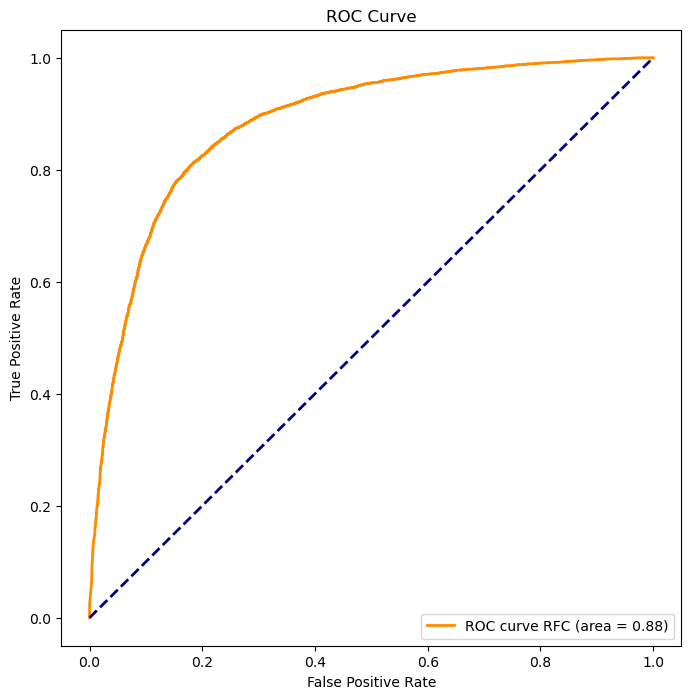

In [60]:
# Roc Eğrisi BNB
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
y_scoresBernoulliNB = BNB.predict_proba(x_test)[:, 1]

# ROC eğrisini hesapla
fprBNB, tprBNB, thresholdsBNB = roc_curve(y_test, y_scoresBernoulliNB)
roc_aucBNB = auc(fprBNB, tprBNB)

# ROC eğrisini çiz 
plt.figure(figsize=(8, 8))
plt.plot(fprBNB, tprBNB, color='darkorange', lw=2, label=f'ROC curve RFC (area = {roc_aucBNB:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

## GUSSIANNB

In [64]:
print("GaussianNB başladı")
from sklearn.naive_bayes import GaussianNB 
GNB = GaussianNB()
GNB.fit(x_train,y_train)
AccuracyGaussianNB = cross_val_score(estimator = GNB, X = x_train,y = y_train, cv=10)
y_predGaussianNB = GNB.predict(x_test)
print("GaussianNB bitti")

GaussianNB başladı


C:\Users\HepsiBTC\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HepsiBTC\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HepsiBTC\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HepsiBTC\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

GaussianNB bitti


C:\Users\HepsiBTC\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [65]:
accuracy_scoreGaussianNB = accuracy_score(y_test, y_predGaussianNB)
f1_scoreGaussianNB = f1_score(y_test, y_predGaussianNB)
recall_scoreGaussianNB = recall_score(y_test, y_predGaussianNB)
hamming_lossGaussianNB = hamming_loss(y_test, y_predGaussianNB)
zero_one_lossGaussianNB = zero_one_loss(y_test, y_predGaussianNB, normalize=False)
precision_scoreGaussianNB = precision_score(y_test, y_predGaussianNB)

In [67]:
print("accuracy_scoreBGaussianNB: {}".format(accuracy_scoreGaussianNB))
print("f1_scoreGaussianNB: {}".format(f1_scoreGaussianNB))
print("recall_scoreGaussianNB: {}".format(recall_scoreGaussianNB))
print("hamming_lossGaussianNB: {}".format(hamming_lossGaussianNB))
print("zero_one_lossGaussianNB: {}".format(zero_one_lossGaussianNB))
print("precision_scoreGaussianNB: {}".format(precision_scoreGaussianNB))

accuracy_scoreBGaussianNB: 0.8207222222222222
f1_scoreGaussianNB: 0.8037940049857116
recall_scoreGaussianNB: 0.7450405770964833
hamming_lossGaussianNB: 0.17927777777777779
zero_one_lossGaussianNB: 3227
precision_scoreGaussianNB: 0.8726072607260726


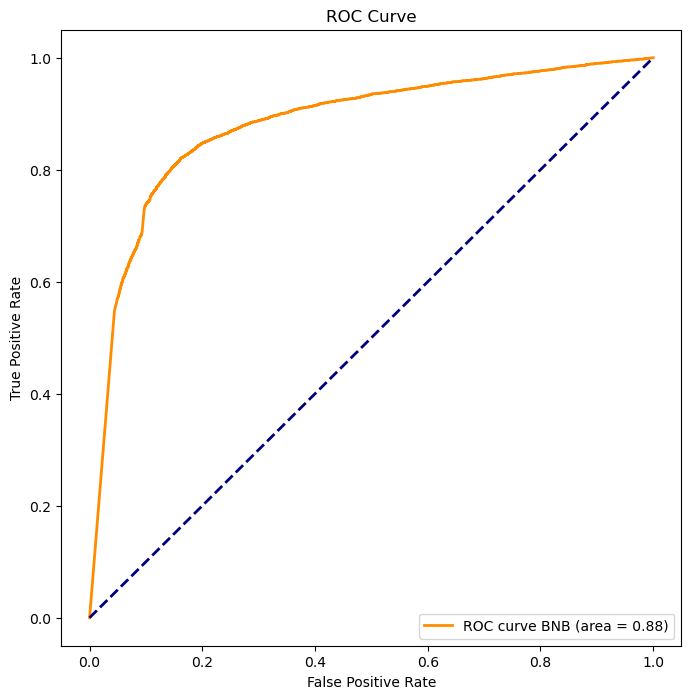

In [69]:
# Roc Eğrisi GNB
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
y_scoresGaussianNB = GNB.predict_proba(x_test)[:, 1]

# ROC eğrisini hesapla
fprGNB, tprGNB, thresholdsGNB = roc_curve(y_test, y_scoresGaussianNB)
roc_aucGNB = auc(fprGNB, tprGNB)

# ROC eğrisini çiz 
plt.figure(figsize=(8, 8))
plt.plot(fprGNB, tprGNB, color='darkorange', lw=2, label=f'ROC curve BNB (area = {roc_aucGNB:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

## Decision Tree Classifier

In [73]:
print("DecisionTreeClassifier başladı")
from sklearn.tree import DecisionTreeClassifier
Dtree = DecisionTreeClassifier(random_state=0)
Dtree.fit(x_train,y_train)
AccuracyDecisionTreeClassifier = cross_val_score(estimator = Dtree, X = x_train,y = y_train, cv=10)
y_predDTC = Dtree.predict(x_test)
print("DecisionTreeClassifier bitti")

DecisionTreeClassifier başladı
DecisionTreeClassifier bitti


In [75]:
accuracy_scoreDTC = accuracy_score(y_test, y_predDTC)
f1_scoreDTC = f1_score(y_test, y_predDTC)
recall_scoreDTC = recall_score(y_test, y_predDTC)
hamming_lossDTC = hamming_loss(y_test, y_predDTC)
zero_one_lossDTC = zero_one_loss(y_test, y_predDTC, normalize=False)
precision_scoreDTC = precision_score(y_test, y_predDTC)

In [80]:
print("accuracy_scoreDecisionTreeClassifier: {}".format(accuracy_scoreDTC))
print("f1_scoreDecisionTreeClassifier: {}".format(f1_scoreDTC))
print("recall_scoreDecisionTreeClassifier: {}".format(recall_scoreDTC))
print("hamming_lossDecisionTreeClassifierB: {}".format(hamming_lossDTC))
print("zero_one_lossDecisionTreeClassifier: {}".format(zero_one_lossDTC))
print("precision_scoreDecisionTreeClassifier: {}".format(precision_scoreDTC))

accuracy_scoreDecisionTreeClassifier: 0.8278333333333333
f1_scoreDecisionTreeClassifier: 0.8280911965385255
recall_scoreDecisionTreeClassifier: 0.8412984670874661
hamming_lossDecisionTreeClassifierB: 0.17216666666666666
zero_one_lossDecisionTreeClassifier: 3099
precision_scoreDecisionTreeClassifier: 0.8152921900600765


## Extra Tree Classifier

In [77]:
print("ExtraTreeClassifier başladı")
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import ExtraTreeClassifier
extra_tree = ExtraTreeClassifier(random_state=0)
BC = BaggingClassifier(extra_tree, random_state=0).fit(x_train, y_train)
AccuracyExtra_tree = cross_val_score(estimator = BC, X = x_train,y = y_train, cv=10)
y_predETC = BC.predict(x_test)
print("ExtraTreeClassifier bitti")

ExtraTreeClassifier başladı


C:\Users\HepsiBTC\anaconda3\Lib\site-packages\sklearn\ensemble\_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HepsiBTC\anaconda3\Lib\site-packages\sklearn\ensemble\_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HepsiBTC\anaconda3\Lib\site-packages\sklearn\ensemble\_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HepsiBTC\anaconda3\Lib\site-packages\sklearn\ensemble\_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

ExtraTreeClassifier bitti


In [83]:
accuracy_scoreETC= accuracy_score(y_test, y_predETC)
f1_scoreETC = f1_score(y_test, y_predETC)
recall_scoreETC = recall_score(y_test, y_predETC)
hamming_lossETC = hamming_loss(y_test, y_predETC)
zero_one_lossETC = zero_one_loss(y_test, y_predETC, normalize=False)
precision_scoreETC = precision_score(y_test, y_predETC)

In [86]:
print("accuracy_scoreExtraTreeClassifier: {}".format(accuracy_scoreETC))
print("f1_scoreExtraTreeClassifier: {}".format(f1_scoreETC))
print("recall_scoreExtraTreeClassifier: {}".format(recall_scoreETC))
print("hamming_lossExtraTreeClassifier: {}".format(hamming_lossETC))
print("zero_one_lossExtraTreeClassifier: {}".format(zero_one_lossETC))
print("precision_scoreExtraTreeClassifier: {}".format(precision_scoreETC))

accuracy_scoreExtraTreeClassifier: 0.8555555555555555
f1_scoreExtraTreeClassifier: 0.8492753623188406
recall_scoreExtraTreeClassifier: 0.8256311992786294
hamming_lossExtraTreeClassifier: 0.14444444444444443
zero_one_lossExtraTreeClassifier: 2600
precision_scoreExtraTreeClassifier: 0.8743136786822631


## K-NNeighbors Classifier

In [85]:
#%%KNeighborsClassifier
print("KNeighborsClassifier başladı")
from sklearn.neighbors import KNeighborsClassifier
KNN = KNeighborsClassifier(n_neighbors=3)
KNN.fit(x_test, y_test)
AccuracyKNN = cross_val_score(estimator = KNN, X = x_train,y = y_train, cv=10)
y_predKNNC = KNN.predict(x_test)
print("KNeighborsClassifier bitti")


KNeighborsClassifier başladı


C:\Users\HepsiBTC\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\HepsiBTC\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\HepsiBTC\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\HepsiBTC\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

KNeighborsClassifier bitti


In [87]:
accuracy_scoreKNNC= accuracy_score(y_test, y_predKNNC)
f1_scoreKNNC = f1_score(y_test, y_predKNNC)
recall_scoreKNNC = recall_score(y_test, y_predKNNC)
hamming_lossKNNC = hamming_loss(y_test, y_predKNNC)
zero_one_lossKNNC = zero_one_loss(y_test, y_predKNNC, normalize=False)
precision_scoreKNNC = precision_score(y_test, y_predKNNC)

In [88]:
print("accuracy_scoreKNeighborsClassifier: {}".format(accuracy_scoreKNNC))
print("f1_scoreKNeighborsClassifier: {}".format(f1_scoreKNNC))
print("recall_scoreKNeighborsClassifier: {}".format(recall_scoreKNNC))
print("hamming_lossKNeighborsClassifier: {}".format(hamming_lossKNNC))
print("zero_one_lossKNeighborsClassifier: {}".format(zero_one_lossKNNC))
print("precision_scoreKNeighborsClassifier: {}".format(precision_scoreKNNC))

accuracy_scoreKNeighborsClassifier: 0.7617777777777778
f1_scoreKNeighborsClassifier: 0.7995699728895953
recall_scoreKNeighborsClassifier: 0.9640441839495041
hamming_lossKNeighborsClassifier: 0.23822222222222222
zero_one_lossKNeighborsClassifier: 4288
precision_scoreKNeighborsClassifier: 0.6830378533780547


## MLPClassifier

In [90]:
print("MLPClassifier başladı")
from sklearn.neural_network import MLPClassifier
MLP = MLPClassifier(random_state=1, max_iter=300)
MLP.fit(x_train, y_train)
AccuracyMLP = cross_val_score(estimator = MLP, X = x_train,y = y_train, cv=10)
y_predMLPC = MLP.predict(x_test)
print("MLPClassifier bitti")
print(AccuracyMLP)

MLPClassifier başladı


C:\Users\HepsiBTC\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HepsiBTC\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HepsiBTC\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HepsiBTC\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A colu

MLPClassifier bitti
[0.87214286 0.8702381  0.87261905 0.86547619 0.86357143 0.86404762
 0.87428571 0.86452381 0.85904762 0.86547619]


In [91]:
accuracy_scoreMLPC= accuracy_score(y_test, y_predMLPC)
f1_scoreMLPC = f1_score(y_test, y_predMLPC)
recall_scoreMLPC = recall_score(y_test, y_predMLPC)
hamming_lossMLPC = hamming_loss(y_test, y_predMLPC)
zero_one_lossMLPC = zero_one_loss(y_test, y_predMLPC, normalize=False)
precision_scoreMLPC = precision_score(y_test, y_predMLPC)

In [92]:
print("accuracy_scoreMLPClassifier: {}".format(accuracy_scoreMLPC))
print("f1_scoreMLPClassifier: {}".format(f1_scoreMLPC))
print("recall_scoreMLPClassifierr: {}".format(recall_scoreMLPC))
print("hamming_lossMLPClassifier: {}".format(hamming_lossMLPC))
print("zero_one_lossMLPClassifier: {}".format(zero_one_lossMLPC))
print("precision_scoreMLPClassifier: {}".format(precision_scoreMLPC))

accuracy_scoreMLPClassifier: 0.8678333333333333
f1_scoreMLPClassifier: 0.8678259903327962
recall_scoreMLPClassifierr: 0.880297565374211
hamming_lossMLPClassifier: 0.13216666666666665
zero_one_lossMLPClassifier: 2379
precision_scoreMLPClassifier: 0.8557028596472006


## RandomForestClassifier

In [93]:
print("RandomForestClassifier başladı")
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier(max_depth=2, random_state=0)
RFC.fit(x_train, y_train)
AccuracyRFC = cross_val_score(estimator = RFC, X = x_train,y = y_train, cv=10)
y_predRFC = RFC.predict(x_test)

print("RandomForestClassifier bitti")

RandomForestClassifier başladı


C:\Users\HepsiBTC\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\HepsiBTC\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\HepsiBTC\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\HepsiBTC\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sa

RandomForestClassifier bitti


In [94]:
accuracy_scoreRFC= accuracy_score(y_test, y_predRFC)
f1_scoreRFC = f1_score(y_test, y_predRFC)
recall_scoreRFC = recall_score(y_test, y_predRFC)
hamming_lossRFC = hamming_loss(y_test, y_predRFC)
zero_one_lossRFC = zero_one_loss(y_test, y_predRFC, normalize=False)
precision_scoreRFC = precision_score(y_test, y_predRFC)

In [95]:
print("accuracy_scoreRandomForestClassifier : {}".format(accuracy_scoreRFC))
print("f1_scoreRandomForestClassifier : {}".format(f1_scoreRFC))
print("recall_scoreRandomForestClassifier : {}".format(recall_scoreRFC))
print("hamming_lossRandomForestClassifier : {}".format(hamming_lossRFC))
print("zero_one_lossRandomForestClassifier : {}".format(zero_one_lossRFC))
print("precision_scoreRandomForestClassifier r: {}".format(precision_scoreRFC))

accuracy_scoreRandomForestClassifier : 0.8183333333333334
f1_scoreRandomForestClassifier : 0.8312519351842295
recall_scoreRandomForestClassifier : 0.907799819657349
hamming_lossRandomForestClassifier : 0.18166666666666667
zero_one_lossRandomForestClassifier : 3270
precision_scoreRandomForestClassifier r: 0.7666095564439368


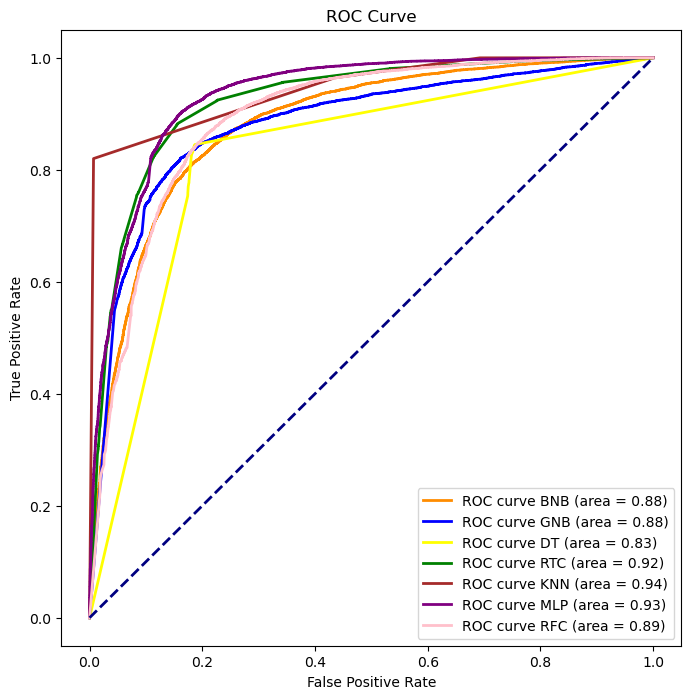

In [98]:
# Roc Eğrisi GNB
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
y_scoresBernoulliNB = BNB.predict_proba(x_test)[:, 1]
y_scoresGaussianNB = GNB.predict_proba(x_test)[:, 1]
y_scoresDtree = Dtree.predict_proba(x_test)[:, 1]
y_scoresETC = BC.predict_proba(x_test)[:, 1]
y_scoresKNN = KNN.predict_proba(x_test)[:, 1]
y_scoresMLP = MLP.predict_proba(x_test)[:, 1]
y_scoresRFC = RFC.predict_proba(x_test)[:, 1]

# ROC eğrisini hesapla
fprBNB, tprBNB, thresholdsBNB = roc_curve(y_test, y_scoresBernoulliNB)
roc_aucBNB = auc(fprBNB, tprBNB)

fprGNB, tprGNB, thresholdsGNB = roc_curve(y_test, y_scoresGaussianNB)
roc_aucGNB = auc(fprGNB, tprGNB)

fprDT, tprDT, thresholdsDT = roc_curve(y_test, y_scoresDtree)
roc_aucDT = auc(fprDT, tprDT)

fprETC, tprETC, thresholdsETC = roc_curve(y_test, y_scoresETC)
roc_aucETC = auc(fprETC, tprETC)

fprKNN, tprKNN, thresholdsKNN = roc_curve(y_test, y_scoresKNN)
roc_aucKNN = auc(fprKNN, tprKNN)

fprMLP, tprMLP, thresholdsMLP = roc_curve(y_test, y_scoresMLP)
roc_aucMLP = auc(fprMLP, tprMLP)

fprRFC, tprRFC, thresholdsRFC = roc_curve(y_test, y_scoresRFC)
roc_aucRFC= auc(fprRFC, tprRFC)


# ROC eğrisini çiz 
plt.figure(figsize=(8, 8))
plt.plot(fprBNB, tprBNB, color='darkorange', lw=2, label=f'ROC curve BNB (area = {roc_aucBNB:.2f})')
plt.plot(fprGNB, tprGNB, color='blue', lw=2, label=f'ROC curve GNB (area = {roc_aucGNB:.2f})')
plt.plot(fprDT, tprDT, color='yellow', lw=2, label=f'ROC curve DT (area = {roc_aucDT:.2f})')
plt.plot(fprETC, tprETC, color='green', lw=2, label=f'ROC curve RTC (area = {roc_aucETC:.2f})')
plt.plot(fprKNN, tprKNN, color='brown', lw=2, label=f'ROC curve KNN (area = {roc_aucKNN:.2f})')
plt.plot(fprMLP, tprMLP, color='purple', lw=2, label=f'ROC curve MLP (area = {roc_aucMLP:.2f})')
plt.plot(fprRFC, tprRFC, color='pink', lw=2, label=f'ROC curve RFC (area = {roc_aucRFC:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()